In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import re

# Data Cleaning

##### remove upper_case (df_series_analysis)
#### drop tokens_raw

In [2]:
#transcripts from source1
df_breakingbad = pickle.load(open('df_breakingbad', 'rb'))
df_breakingbad.reset_index(inplace=True, drop=True)

In [3]:
#dropping corrupted transcripts (transcripts in another language)
corrupted_data = ['S1E7: A No-Rough-Stuff-Type Deal', 'S2E8: Better Call Saul', 'S2E13: ABQ']
corrupted_index = df_breakingbad[df_breakingbad['season_episode_names'].isin(corrupted_data)].index.values #sorts index automatically

#transcripts source2
dict_breakingbad = pickle.load(open('dict_breakingbad', 'rb'))
df_breakingbad_2 = pd.DataFrame.from_dict(dict_breakingbad)
index_episode1 = df_breakingbad_2[df_breakingbad_2['episode'].str.contains('A-No-Rough-Stuff-Type-Deal')].index.values
index_episode2 = df_breakingbad_2[df_breakingbad_2['episode'].str.contains('Better Call Saul')].index.values
index_episode3 = df_breakingbad_2[df_breakingbad_2['episode'].str.contains('ABQ')].index.values #ok

df_breakingbad.loc[corrupted_index[0], 'transcripts'] = df_breakingbad_2.loc[int(index_episode1), 'transcripts']
df_breakingbad.loc[corrupted_index[1], 'transcripts'] = df_breakingbad_2.loc[int(index_episode2), 'transcripts']
df_breakingbad.loc[corrupted_index[2], 'transcripts'] = df_breakingbad_2.loc[int(index_episode3), 'transcripts']

In [4]:
%store -r df_nation
%store -r df_series_groups

In [5]:
#df_nation grouped by level_frequency 
# 0 -> 26 (proper_names) , 27 (marginal_words), 28 (compounds), 29 (acronyms)
# (5-25) -> levels from 5 to 15
#df_nation grouped by levels_coverage
# 15 -> (15: list between 15 and 25)

# df_nation.groupby('levels').count()
# df_nation.groupby('levels_frequency').count()
df_nation.groupby('levels_coverage').count() 
df_nation.sort_values('all_forms')

,base_forms,all_forms,levels,levels_frequency,levels_coverage
56173,a,a,1,1,1
1149,a1,a1,26,0,26
1150,a11,a11,26,0,26
1151,a168,a168,26,0,26
1152,a19,a19,26,0,26
...,...,...,...,...,...
30895,emigre,émigrés,12,5-25,12
69601,esprit,ésprit,16,5-25,15
89976,etoile,étoile,20,5-25,15
52372,etudes,étude,15,5-25,15


### Cleaning non-English letters

In [6]:
#'ν' --> 'v'
df_breakingbad['transcripts'] = df_breakingbad['transcripts'].apply(lambda x:re.sub('ν', 'v', x))
# 'l'--> i e.g. lmp (imposible) -> There's a problem coming from the source of the transcripts itself
# all i in upper case are treated as l (l in lower case) Fortunately most of them are pronouns like 'I' , but some words starting with 'i' in upper case are lost (small %)

In [7]:
df_breakingbad['raw_tokens'] = df_breakingbad['transcripts'].apply(lambda x:len(x.split()))

In [8]:
#the difference between tokens_raw and tokens shouldn't be so much since only speaker's name,
#words within parentheses and squarebrackets were removed
print('Min Raw: ' + str(df_breakingbad['raw_tokens'].min()))
# #and only contractions were added "'n" --> 'not'
print('Max Raw: ' + str(df_breakingbad['raw_tokens'].max()))

Min Raw: 2383
Max Raw: 4544


In [9]:
#seaborn
#sns.boxplot(x=df_breakingbad['raw_tokens'])

#first boxplot
# import plotly_express as px
# import plotly.graph_objects as go
# from plotly.offline import iplot, init_notebook_mode

# fig = go.Figure()
# fig.add_box(x=df_breakingbad['raw_tokens'], text=df_breakingbad.index)
# iplot(fig)

In [10]:
# cleaning transcripts
#keep in mind that some transcripts contain comma with no space like 'hi,how are you' or " instead of ' like 'you"re'. after cleaning they, the trancsripts become useless
from cleaning import clean_transcripts

round1 = lambda x: clean_transcripts(x)
df_breakingbad['transcripts'] = df_breakingbad['transcripts'].apply(round1)

In [11]:
# df_series_clean_except_transcripts.groupby('series_titles').count()
df_breakingbad = df_breakingbad.assign(tokens=df_breakingbad['transcripts'].apply(lambda x:len(x.split())))

In [12]:
#the difference between tokens_raw and tokens shouldn't be so much since only speaker's name,
#words within parentheses and squarebrackets were removed
print('Min Raw: ' + str(df_breakingbad['raw_tokens'].min()) + ', Min Clean: '+ str(df_breakingbad['tokens'].min()))
# #and only contractions were added "'n" --> 'not'
print('Max Raw: ' + str(df_breakingbad['raw_tokens'].max()) + ', Max Clean: '+ str(df_breakingbad['tokens'].max()))

Min Raw: 2383, Min Clean: 2501
Max Raw: 4544, Max Clean: 4760


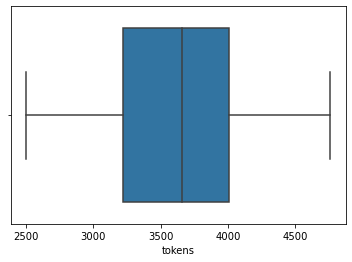

In [13]:
sns.boxplot(x=df_breakingbad['tokens'])

### Episodes with less dialogues (less words to worry about)

In [14]:
df_breakingbad.sort_values('raw_tokens')[:5]

,transcripts,series_titles,years,seasons,season_episodes,season_episode_names,raw_tokens,tokens
33,how s it coming very very well it s a flurry o...,breaking bad,2008,4,1,S4E1: Box Cutter,2383,2501
22,sync by honeybunny he s still breathing by th...,breaking bad,2008,3,3,S3E3: I.F.T.,2457,2610
42,advertise your product or brand here contact ...,breaking bad,2008,4,10,S4E10: Salud,2585,2601
26,hey you got nothing on me yo all right you ca...,breaking bad,2008,3,7,S3E7: One Minute,2682,2818
16,you re not thinking about going to work today ...,breaking bad,2008,2,10,S2E10: Over,2688,2854


# Exploratory Data Analysis

### Document-Term Matrix¶

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import scipy.sparse
cv = CountVectorizer()#only misleading words excluded for the analysis
cv_matrix = cv.fit_transform(df_breakingbad['transcripts'])
df_dtm = pd.DataFrame.sparse.from_spmatrix(cv_matrix, index=df_breakingbad.index,
                                           columns=cv.get_feature_names())

In [16]:
df_dtm = df_dtm.T

# Formula

In [17]:
def get_frames(indices, dtm, thousand_level=None): #, thousand_level ['4'], ['5-14']
    """1. The df_dtm gives the number of times a word (all_forms) shows up in an episode/movie
       2. Then its joined to get the level and base_forms of each word
       3. The final df has the words counted for each episode so it can be seen base_forms repetition in the final df"""
    frames = []
    for index in indices:
        df_count_words = dtm[[index]].loc[dtm[index]!=0]
        df_count_words = df_count_words.reset_index()
        df_count_words.rename(columns={"index": "all_forms", index: "count"}, inplace=True)

        df_count_words_level = pd.merge(df_count_words, df_nation[['base_forms', 'all_forms',
                                'levels_frequency', 'levels', 'levels_coverage']], how='left', on='all_forms', indicator=True)
        df_count_words_level.loc[df_count_words_level['_merge']=='left_only', 'levels_coverage'] = 100
        if thousand_level is not None: #only consider words in specific levels
            df_count_words_level = df_count_words_level[df_count_words_level['levels_frequency'].isin(thousand_level)]
        frames.append(df_count_words_level)
    df_count_words_level = pd.concat(frames)
    return df_count_words_level

In [18]:
def get_coverage(indices, df_dtm):
    frames = []
    for episode_index in indices:
        df_coverage_episode = get_frames([episode_index], df_dtm) ##
        df_coverage_episode = df_coverage_episode[['count' ,'levels_coverage']].groupby('levels_coverage').sum()
        df_coverage_episode.drop([28, 29], axis=0, inplace=True, errors='ignore')
        df_coverage_episode['%'] = 100 * (round(df_coverage_episode['count']/
                                            df_coverage_episode['count'].sum(), 4))
        df_coverage_episode = df_coverage_episode.reset_index()
        condition = [(df_coverage_episode['levels_coverage']<=4),
            (df_coverage_episode['levels_coverage']>=5) & (df_coverage_episode['levels_coverage']<=15),
                    (df_coverage_episode['levels_coverage']>=26)] #15 includes list from 15 to 25
        values = [df_coverage_episode['levels_coverage'], 5, df_coverage_episode['levels_coverage']]
        df_coverage_episode['lvl'] = np.select(condition, values)
        df_coverage_episode = df_coverage_episode.groupby('lvl').sum()
        df_coverage_episode['cumulative'] = df_coverage_episode['%'].cumsum()
        if len(indices)==1:   
            df_coverage_episode = df_coverage_episode[['count', '%']].T.reset_index(drop=True)
        elif len(indices)>1:
            df_coverage_episode = df_coverage_episode[['%']].T.reset_index(drop=True)
            df_coverage_episode['index'] = episode_index
        frames.append(df_coverage_episode)
    return frames

### Vocabulary coverage of a random episode

In [19]:
index = 57 #episode number is different from index!!!
series_name = 'The Big Bang Theory'
df_random_episode = get_coverage([index], df_dtm)[0]
df_random_episode.rename(columns={26:'Character names', 27:'Interjections', 
                                  100:series_name+" words"}, inplace=True)
df_random_episode.T.rename(columns={0:'count', 1:'%'})

,count,%
lvl,,
1.0,3215.0,89.03
2.0,127.0,3.52
3.0,25.0,0.69
4.0,30.0,0.83
5.0,63.0,1.74
Character names,72.0,1.99
Interjections,58.0,1.61
The Big Bang Theory words,21.0,0.58


### Unique words in the TV show

In [53]:
df_words_series = get_frames(df_breakingbad.index.values, df_dtm)
df_words_series = df_words_series[['all_forms', 'count', 'levels_coverage']]
#names
df_words_series = df_words_series[(df_words_series['levels_coverage']==26)|(df_words_series['levels_coverage']==100)]
df_words_series

#check .groupby sparse(int64)
list_words = list(df_words_series['all_forms'])
list_count = list(df_words_series['count'])

### Wordcloud

In [69]:
# character_name = ['wolowitz', 'wheaton', 'priya', 'kripke', 'nowitzki', 'koothrappali', 'hofstadter',
#                  'rajesh', 'lalita', 'siebert', 'anu', 'ruchi', 'rostenkowski']
# some transcripts have words such as You"re, don"t -> my cleaning.py doesn't sub ", but '
clean_words = ['youre', 'dont', 'didnt', 'youll', 'youve', 'shes', 'doesnt', 'sub', 'maam',
               'facebook', 'bitcoin','elderman', 'autotrophs', 'ew', 'grad', 'opensubtitlesorg']#sync corrected...., 'autotrophs' part of the song, grad student
character_name.extend(clean_words)

df_words_series = pd.DataFrame({'words':list_words, 'count':list_count})
df_words_series = df_words_series.groupby('words', as_index=False).sum().sort_values('count', ascending=False)

# words only found in the series excluding character names
df_words_series = df_words_series[~df_words_series['words'].isin(character_name)]
df_words_series['words'] = df_words_series['words'].apply(lambda x:x+' ')
df_words_series['text'] = df_words_series['words']*df_words_series['count']
words = ''.join(df_words_series['text'])

import stylecloud
from wordcloud import STOPWORDS

#FF5733
#900C3F
stylecloud.gen_stylecloud(words, palette="cmocean.sequential.Matter_16", 
                          background_color="white", icon_name= "fas fa-vials",
                          colors=['#3C905B', '#3C905B', '#3C905B'], collocations=False)

### Character names

In [74]:
#words repeated in all episodes in list 100 (TV series own vocabulary, particular phrases)
df_words_series.sort_values('count',ascending=False)[:10][['words', 'count']]
#find where those words were spoken
# df_breakingbad[df_breakingbad['transcripts'].str.contains('bitcoin')]
# df_breakingbad.loc[235, 'transcripts']

,words,count
1338,walt,439
604,jesse,377
500,hank,343
1139,skyler,264
745,marie,197
605,jesus,149
1339,walter,148
798,mike,137
947,pinkman,112
1084,saul,95


### Vocabulary coverage of the average GoT episode - Should I watch Friends, The Simpsons or GoT?

In [23]:
frames = get_coverage(df_breakingbad.index.values, df_dtm)

In [24]:
pd.concat(frames, axis=0, ignore_index=True)[[1, 2, 3, 4, 5, 26, 27, 100]].mean()

lvl
1.0      87.644839
2.0       3.854839
3.0       1.281774
4.0       0.831129
5.0       2.158387
26.0      2.000323
27.0      1.236613
100.0     0.991452
dtype: float64

### Vocabulary coverage in all episodes

In [25]:
df_statistics = pd.concat(frames, axis=0, ignore_index=True)[['index', 1, 2, 3, 4, 5, 26, 27, 100]]
df_statistics = df_statistics.fillna(0)
#assume you know interjections, character names and words created in the tv series
df_statistics['Lvl 1'] = df_statistics[1] + df_statistics[26] + df_statistics[27] + df_statistics[100]
df_statistics['Lvl 1+2'] = df_statistics['Lvl 1'] + df_statistics[2]
df_statistics['Lvl 1+2+3'] = df_statistics['Lvl 1+2'] + df_statistics[3]
df_statistics['Lvl 1+2+3+4'] = df_statistics['Lvl 1+2+3'] + df_statistics[4]
df_statistics = pd.concat((df_statistics.set_index('index'), df_breakingbad[['season_episode_names', 'seasons']]), axis=1)
df_statistics

,1.0,2.0,3.0,4.0,5.0,26.0,27.0,100.0,Lvl 1,Lvl 1+2,Lvl 1+2+3,Lvl 1+2+3+4,season_episode_names,seasons
0,86.23,4.21,1.24,1.09,3.25,1.90,0.95,1.15,90.23,94.44,95.68,96.77,S1E1: Pilot,1
1,87.86,4.84,1.14,0.73,2.18,1.14,1.11,1.00,91.11,95.95,97.09,97.82,S1E2: Cat's in the Bag...,1
2,87.47,3.68,0.95,0.86,2.13,1.51,2.37,1.02,92.37,96.05,97.00,97.86,S1E3: ...And the Bag's in the River,1
3,84.62,4.51,1.47,0.84,3.04,1.68,3.18,0.65,90.13,94.64,96.11,96.95,S1E4: Cancer Man,1
4,89.24,3.45,0.82,0.88,2.14,2.13,0.73,0.61,92.71,96.16,96.98,97.86,S1E5: Gray Matter,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,89.03,3.52,0.69,0.83,1.74,1.99,1.61,0.58,93.21,96.73,97.42,98.25,S5E12: Rabid Dog,5
58,87.00,3.57,0.81,1.11,1.64,3.30,1.90,0.66,92.86,96.43,97.24,98.35,S5E13: To'hajiilee,5
59,88.52,3.16,0.46,0.59,1.62,3.33,1.37,0.95,94.17,97.33,97.79,98.38,S5E14: Ozymandias,5
60,89.18,3.58,0.87,0.61,1.52,2.21,1.16,0.87,93.42,97.00,97.87,98.48,S5E15: Granite State,5


#### Filtering more episodes out (with list 100)

In [26]:
#rule of thum % in list 100 <3.5
#most of the words in list 100 of the episode S12E3 are 'you"re' or 'don"t' so it's fine to consider them in LVL1
df_statistics.sort_values(100, ascending=False)[:10]

,1.0,2.0,3.0,4.0,5.0,26.0,27.0,100.0,Lvl 1,Lvl 1+2,Lvl 1+2+3,Lvl 1+2+3+4,season_episode_names,seasons
38,85.12,3.16,1.07,0.24,1.93,2.37,2.68,3.44,93.61,96.77,97.84,98.08,S4E6: Cornered,4
32,86.87,3.56,0.98,0.89,1.67,1.60,1.72,2.70,92.89,96.45,97.43,98.32,S3E13: Full Measure,3
8,86.70,3.66,1.66,0.59,2.72,2.35,0.76,1.55,91.36,95.02,96.68,97.27,S2E2: Grilled,2
54,85.85,3.73,1.13,0.97,2.00,3.14,1.66,1.51,92.16,95.89,97.02,97.99,S5E9: Blood Money,5
23,86.63,4.03,1.22,0.53,2.24,1.99,1.90,1.48,92.00,96.03,97.25,97.78,S3E4: Green Light,3
43,88.50,3.15,0.76,0.68,1.95,2.09,1.49,1.38,93.46,96.61,97.37,98.05,S4E11: Crawl Space,4
9,87.28,4.08,1.23,0.86,2.80,1.69,0.69,1.35,91.01,95.09,96.32,97.18,S2E3: Bit by a Dead Bee,2
22,88.40,3.88,1.02,0.47,1.59,1.15,2.17,1.32,93.04,96.92,97.94,98.41,S3E3: I.F.T.,3
13,86.78,3.50,1.52,0.89,2.79,2.01,1.23,1.29,91.31,94.81,96.33,97.22,S2E7: Negro Y Azul,2
55,89.81,2.67,0.96,0.35,0.83,2.86,1.25,1.25,95.17,97.84,98.80,99.15,S5E10: Buried,5


### Top 10 GoT episodes (easies vocabulary)

In [27]:
for i in df_statistics.sort_values(['Lvl 1'], ascending=False)[:10].values:
    print(i[12])

S5E10: Buried
S4E12: End Times
S5E14: Ozymandias
S5E16: Felina
S4E6: Cornered
S4E11: Crawl Space
S5E15: Granite State
S4E10: Salud
S4E13: Face Off
S5E12: Rabid Dog


### ScatterPlot

In [28]:
#preparing data
df_statistics = df_statistics.sort_values('Lvl 1', ascending=False)
df_1 = df_statistics[['Lvl 1', 'season_episode_names']]
df_1 = df_1.assign(label = 'Lvl 1')
df_1.rename(columns={'Lvl 1':'lvl'}, inplace=True)
df_2 = df_statistics[['Lvl 1+2', 'season_episode_names']]
df_2 = df_2.assign(label = 'Lvl 1+2')
df_2.rename(columns={'Lvl 1+2':'lvl'}, inplace=True)
df_3 = df_statistics[['Lvl 1+2+3', 'season_episode_names']]
df_3 = df_3.assign(label = 'Lvl 1+2+3')
df_3.rename(columns={'Lvl 1+2+3':'lvl'}, inplace=True)
df_4 = df_statistics[['Lvl 1+2+3+4', 'season_episode_names']]
df_4 = df_4.assign(label = 'Lvl 1+2+3+4')
df_4.rename(columns={'Lvl 1+2+3+4':'lvl'}, inplace=True)
df_dot = pd.concat([df_1, df_2, df_3, df_4]) #df_4
df_dot['lvl'] = df_dot['lvl'].apply(lambda x:round(x,1))
df_dot.reset_index(drop=True, inplace=True)

In [29]:
#adding ranking column
rank = df_dot.index.values
df_dot['rank'] = rank+1
df_dot.loc[df_dot['rank']>len(df_statistics), 'rank']='-'
df_dot

,lvl,season_episode_names,label,rank
0,95.2,S5E10: Buried,Lvl 1,1
1,94.4,S4E12: End Times,Lvl 1,2
2,94.2,S5E14: Ozymandias,Lvl 1,3
3,93.9,S5E16: Felina,Lvl 1,4
4,93.6,S4E6: Cornered,Lvl 1,5
...,...,...,...,...
243,96.9,S2E8: Better Call Saul,Lvl 1+2+3+4,-
244,97.1,S2E5: Breakage,Lvl 1+2+3+4,-
245,97.1,S4E2: Thirty-Eight Snub,Lvl 1+2+3+4,-
246,97.4,S4E8: Hermanos,Lvl 1+2+3+4,-


In [30]:
episode_count = []

for index, percentage in enumerate(df_dot['lvl']):
    subset = df_dot.iloc[:index+1]    # Create subset starting at the beginning of dataset until the episode
    count = len(subset[subset['lvl'] == percentage])   # Count all episode with same % in this subset
    episode_count.append(count)
    
df_dot['count'] = episode_count

In [31]:
df_dot['season_episode_names'] = df_dot['season_episode_names'].apply(lambda x:re.sub(',', '', x))

In [32]:
# data for DataWrapper
# for i in df_dot.values:
#     print(i[1] + ' , ' + i[2] + ' , ' + str(i[3]) + ' , ' + str(i[4]) + ' , ' + str(i[0]))

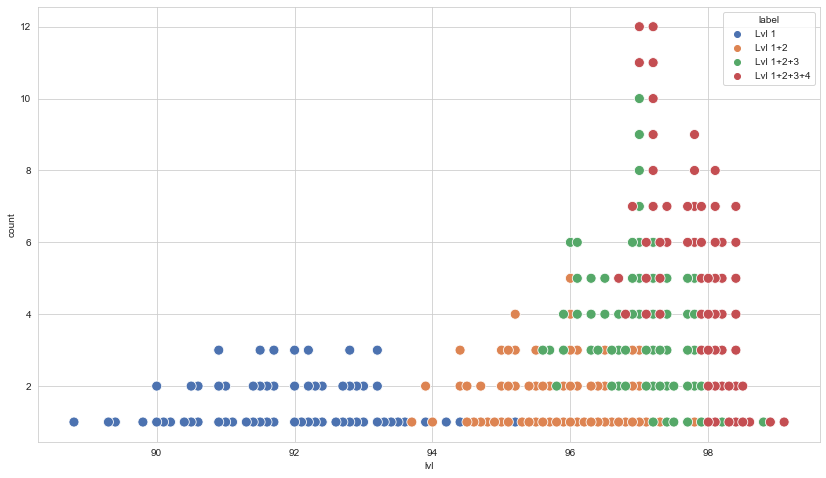

In [33]:
#Static plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.scatterplot(x='lvl', y='count', data=df_dot,
             hue='label', s=100, ax=ax, palette="deep")

# Interactive plot
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode()

# fig = go.Figure()
# for genre, df_genre in df_dot.groupby('label'):
#     fig.add_scatter(x=df_genre["lvl"], y=df_genre['count'], text=df_genre['season_episode_names'],
#     name=genre, mode='markers')
# iplot(fig)

### What hard words are they saying across all GoT episodes?

In [34]:
frames_2 = []
for episode_index in df_breakingbad.index.values:
    df_vocabulary_episode = get_frames([episode_index], df_dtm, ['3', '4', '5-25'])
    df_vocabulary_episode['index'] = episode_index
    frames_2.append(df_vocabulary_episode)

In [35]:
df_breakingbad_lvl = pd.concat(frames_2)
df_breakingbad_lvl = pd.merge(df_breakingbad_lvl, df_breakingbad[['season_episode_names']].reset_index(), on='index')
df_breakingbad_lvl = df_breakingbad_lvl[['all_forms', 'count', 'base_forms', 'levels_frequency', 'season_episode_names']]
df_breakingbad_lvl['season_episode_names'] = df_breakingbad_lvl['season_episode_names'].apply(lambda x:re.sub(',', '', x))
df_breakingbad_lvl
# df_breakingbad_lvl[df_breakingbad_lvl['levels_coverage']>=15]

,all_forms,count,base_forms,levels_frequency,season_episode_names
0,accelerated,1,accelerate,3,S1E1: Pilot
1,admission,1,admission,3,S1E1: Pilot
2,apprehended,1,apprehend,5-25,S1E1: Pilot
3,arroyo,1,arroyo,5-25,S1E1: Pilot
4,ass,6,ass,5-25,S1E1: Pilot
...,...,...,...,...,...
6844,truce,1,truce,5-25,S5E16: Felina
6845,vibe,1,vibe,5-25,S5E16: Felina
6846,wallet,1,wallet,5-25,S5E16: Felina
6847,whoa,3,whoa,5-25,S5E16: Felina


In [36]:
# data for Datawrapper
# for i in df_breakingbad_lvl.values:
#     print(str(i[0])+', '+str(i[1])+', '+str(i[2])+', '+str(i[3])+', '+str(i[4]))